<a href="https://colab.research.google.com/github/GaryBall/CSML_notes/blob/master/heterograph_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# mount the google drive to colab
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.__version__)
print(torch.version.cuda)

2.0.0+cu118
11.8


In [ ]:
!pip install torch_geometric
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install rdkit
!pip install hydra-core wandb hydra-core ray ray-lightning torchmetrics overrides imageio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 25.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910476 sha256=88bf9178175dcb4902391f4b8213e4fac96b9aa3d2c186890ab5edfdd8a45fae
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch_geometric
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 48.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8

In [ ]:
%cd content
!git clone https://github.com/cvignac/MiDi/
%cd MiDi

[Errno 2] No such file or directory: 'content'
/content
fatal: destination path 'MiDi' already exists and is not an empty directory.
/content/MiDi


In [ ]:
from src.datasets import qm9_dataset

In [ ]:
import hydra
import omegaconf

@hydra.main(version_base='1.3', config_path='../configs', config_name='config')
def get_cfg(cfg: omegaconf.DictConfig):
  return cfg





In [ ]:
datamodule = qm9_dataset.QM9DataModule(cfg)
dataset_infos = qm9_dataset.QM9infos(datamodule=datamodule, cfg=cfg)

# Molecule Data

## QM9 dataset

In [ ]:
from torch_geometric.datasets import QM9
from torch_geometric.transforms import NormalizeFeatures

dataset = QM9(root='/tmp/QM9')
dataset = dataset[0:3000]

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: QM9(3000):
Number of graphs: 3000
Number of features: 11
Number of classes: 19

Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], idx=[1], name='gdb_1', z=[5])
Number of nodes: 5
Number of edges: 8
Average node degree: 1.60
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [ ]:
print(data.x)

tensor([[0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 4.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])


In [ ]:
torch.manual_seed(12345)
dataset = dataset.shuffle()

train_dataset = dataset[:2000]
test_dataset = dataset[2000:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 2000
Number of test graphs: 1000


# Synthetic data

In [ ]:
import itertools
import random

# Define the nodes
nodes = ['A', 'B', 'C', 'D']

# Generate all binary combinations
combinations = list(itertools.combinations_with_replacement(nodes, 2))

# Calculate 40% of the total combinations
sample_size = round(len(combinations) * 0.4)

# Randomly sample a subset of the combinations
subset = random.sample(combinations, sample_size)

# Print the results
print("All binary combinations:", combinations)
print("Sampled subset (40%):", subset)


All binary combinations: [('A', 'A'), ('A', 'B'), ('A', 'C'), ('A', 'D'), ('B', 'B'), ('B', 'C'), ('B', 'D'), ('C', 'C'), ('C', 'D'), ('D', 'D')]
Sampled subset (40%): [('C', 'C'), ('B', 'B'), ('C', 'D'), ('A', 'C')]


In [ ]:
import numpy as np
import networkx as n
import random

In [ ]:
import numpy as np
import networkx as nx

def random_unit_vector(K):
    """Generate a random K-dimensional unit vector."""
    v = np.random.randn(K)
    return v / np.linalg.norm(v)

def sample_vectors(K):
    # Generate random K-dimensional unit vectors for X and Y
    X = random_unit_vector(K)
    Y = random_unit_vector(K)

    # Compute the projection of Y onto X
    Y_proj_X = np.dot(X, Y) * X

    # Compute the orthogonal component of Y with respect to X
    Y_orth = Y - Y_proj_X

    # Compute Z by adding a scaled orthogonal component of Y to X
    Z = X + np.sqrt(1 - np.dot(X, Y)**2) * Y_orth / np.linalg.norm(Y_orth)

    return X, Y, Z

# Example usage:
K = 3

X, Y, Z = sample_vectors(K)

print("Sampled X:", X)
print("Sampled Y:", Y)
print("Sampled Z:", Z)
print("X^T * Y =", np.dot(X, Y))
print("Y^T * Z =", np.dot(Y, Z))


Sampled X: [ 0.66462135  0.68144307 -0.30645359]
Sampled Y: [ 0.66046493  0.21117113 -0.72055036]
Sampled Z: [ 0.79094642  0.34495514 -0.78071473]
X^T * Y = 0.803675449902284
Y^T * Z = 1.1577812211266454


# Function for generating Heterogeneous Graphs 

- with Small world assumption - Watts Strogatz Graph

In [6]:
from IPython.terminal.embed import ultratb
import networkx as nx
import random
from collections import deque
from itertools import product
import numpy as np

def ws_graph (n,k,p):
  return nx.watts_strogatz_graph(n, k, p)

def get_available_node_types(current_node, graph, meta_graph):
    if current_node is not None:
      current_node_type = graph.nodes[current_node].get('type')
    else:
      current_node_type = None
    
    # process the case when we randomly select a node to start
    if not current_node_type:
        return list(meta_graph.keys())
    else:
        return list(meta_graph[current_node_type].keys())


def normalize_node_type_prob(available_types, node_type_prob):
    total_prob = sum(node_type_prob[available_types].values())
    node_type_prob_normalized = {}
    for node_type, prob in node_type_prob.items():
      normalized_prob = prob / total_prob
      node_type_prob_normalized[node_type] = normalized_prob

    return node_type_prob_normalized



def generate_heterogeneous_small_world(graph, meta_graph, node_type_prob):
    # Step 1: Generate a Watts-Strogatz graph
    

    # Step 2: Normalize node type probabilities
    node_type_prob_normalized = {node_type: prob / sum(node_type_prob.values()) for node_type, prob in node_type_prob.items()}
    print(node_type_prob_normalized)

    # Step 3: Assign node and edge types using BFS
    visited = set()
    print(graph.nodes())
    current_node = None
    last_node = None

    possible_rel = [(i,j) for i in meta_graph.keys() for j in meta_graph[i].keys()]

    for node in graph.nodes():
        if node not in visited:
            # BFS traversal
            queue = deque([node])
            
            visited.add(node)

            while queue:
                print(queue)
            
                current_node = queue.popleft()
                
                if not graph.nodes[current_node].get('type'):
                  possible_start_type = get_available_node_types(current_node, graph, meta_graph)
                  sample_prob = [node_type_prob_normalized[node_type] for node_type in possible_start_type]
                  node_type = random.choices(possible_start_type, sample_prob, k=1)[0]
                  graph.nodes[current_node]['type'] = node_type

                available_node_types = get_available_node_types(current_node, graph, meta_graph)

                # Assign edge types and add unvisited neighbors to queue
                for neighbor in graph.neighbors(current_node):
                    if neighbor not in visited:
                        # Assign node type
                        if not graph.nodes[neighbor].get('type'):
                            sample_prob = [node_type_prob_normalized[node_type] for node_type in available_node_types]
                            node_type = random.choices(available_node_types, sample_prob, k=1)[0]

                            print(graph.nodes[current_node].get('type'), available_node_types)

                            print("sampled node type for node {vnumber}: {vtype}".format(vnumber = neighbor, vtype = node_type))
                            graph.nodes[neighbor]['type'] = node_type

                        queue.append(neighbor)
                        visited.add(neighbor)

                last_node = current_node
            
    for u, v  in graph.edges():
      if (graph.nodes[u]['type'],graph.nodes[v]['type']) in possible_rel:
        print(u,v, graph.nodes[u]['type'], graph.nodes[v]['type'], meta_graph[graph.nodes[u]['type']][graph.nodes[v]['type']])
        graph.edges[u, v]['type'] = meta_graph[graph.nodes[u]['type']][graph.nodes[v]['type']]
      else:
        print(u,v, graph.nodes[u]['type'], graph.nodes[v]['type'], 'NA')
        graph.edges[u, v]['type'] = 'NA'
    
    return graph

meta_graph = {
    'A': {'C': 'rel_AC'},
    'B': {'C': 'rel_BC'},
    'C': {'A':'rel_AC','B':'rel_BC', 'D':'rel_CD'},
    'D': {'C':'rel_CD','D':'rel_DD'}
}
node_type_prob = {'A': 1, 'B': 1, 'C': 1, 'D': 1}
num_nodes = 20
graph = ws_graph(num_nodes, 3, 0.5)
hetero_graph = generate_heterogeneous_small_world(graph, meta_graph, node_type_prob)


{'A': 0.25, 'B': 0.25, 'C': 0.25, 'D': 0.25}
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
deque([0])
B ['C']
sampled node type for node 1: C
B ['C']
sampled node type for node 18: C
deque([1, 18])
C ['A', 'B', 'D']
sampled node type for node 2: A
deque([18, 2])
C ['A', 'B', 'D']
sampled node type for node 17: B
C ['A', 'B', 'D']
sampled node type for node 7: A
C ['A', 'B', 'D']
sampled node type for node 12: D
deque([2, 17, 7, 12])
A ['C']
sampled node type for node 3: C
deque([17, 7, 12, 3])
B ['C']
sampled node type for node 6: C
deque([7, 12, 3, 6])
A ['C']
sampled node type for node 8: C
deque([12, 3, 6, 8])
D ['C', 'D']
sampled node type for node 11: C
deque([3, 6, 8, 11])
C ['A', 'B', 'D']
sampled node type for node 4: A
deque([6, 8, 11, 4])
C ['A', 'B', 'D']
sampled node type for node 5: A
C ['A', 'B', 'D']
sampled node type for node 16: A
C ['A', 'B', 'D']
sampled node type for node 19: D
deque([8, 11, 4, 5, 16, 19])
deque([11, 4, 5, 16, 19])
deque([4,

## Graph_stats

In [7]:
# find unique relation types
def unique_rel(meta_graph):
  unique_elements = set()
  for inner_dict in meta_graph.values():
    for element in inner_dict.values():
      unique_elements.add(element)

  return unique_elements

print(sorted(unique_rel(meta_graph)))

['rel_AC', 'rel_BC', 'rel_CD', 'rel_DD']


In [8]:
graph.edges

EdgeView([(0, 1), (0, 18), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (5, 10), (6, 17), (6, 16), (6, 19), (7, 18), (7, 8), (9, 10), (9, 14), (11, 12), (12, 18), (13, 19), (15, 16), (17, 18)])

$\nabla(f)$

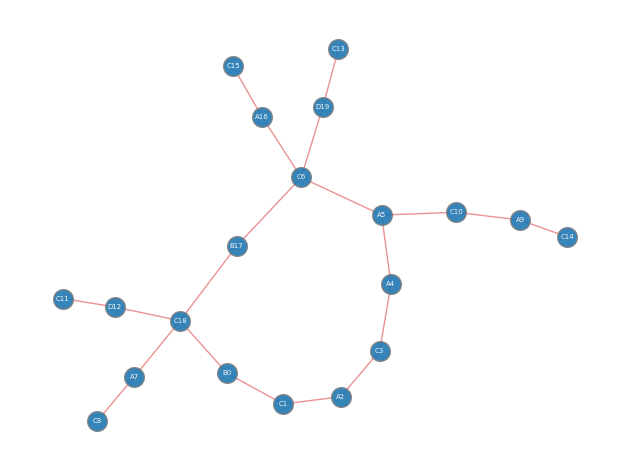

In [9]:
import matplotlib.pyplot as plt

pos = nx.spring_layout(hetero_graph, seed=0)  # positions for all nodes

# nodes
options = {"edgecolors": "tab:gray", "node_size": 200, "alpha": 0.9}
nx.draw_networkx_nodes(hetero_graph, pos, **options)

# edges
nx.draw_networkx_edges(hetero_graph, pos, width=1.0, alpha=0.5, edge_color="tab:red",)

labels = {i: graph.nodes[i]['type']+str(i) for i in range(len(graph.nodes))}
nx.draw_networkx_labels(hetero_graph, pos, labels, font_size=5, font_color="whitesmoke")

plt.tight_layout()
plt.axis("off")
plt.show()

In [47]:
import itertools

def adjacency_tensor(graph, meta_graph):
    edge_types = ['rel_'+i+j for i,j in itertools.combinations_with_replacement(meta_graph.keys(), 2)]
    n = len(graph.nodes())
    r = len(edge_types)

    adj_matrices = []

    for edge_type in edge_types:
        adj_matrix = np.zeros((n, n), dtype=np.int32)
        
        for u, v, data in graph.edges(data=True):
            if data['type'] == edge_type:
                adj_matrix[u, v] = 1
                adj_matrix[v, u] = 1
        
        adj_matrices.append(adj_matrix)

    edge_dict = {i: edge_types[i] for i in range(len(edge_types))}
    return np.stack(adj_matrices, axis=-1), edge_dict

adj_tensor, edge_dict = adjacency_tensor(hetero_graph, meta_graph)
adj_tensor.shape


(20, 20, 10)

In [49]:
edge_dict, meta_graph

({0: 'rel_AA',
  1: 'rel_AB',
  2: 'rel_AC',
  3: 'rel_AD',
  4: 'rel_BB',
  5: 'rel_BC',
  6: 'rel_BD',
  7: 'rel_CC',
  8: 'rel_CD',
  9: 'rel_DD'},
 {'A': {'C': 'rel_AC'},
  'B': {'C': 'rel_BC'},
  'C': {'A': 'rel_AC', 'B': 'rel_BC', 'D': 'rel_CD'},
  'D': {'C': 'rel_CD', 'D': 'rel_DD'}})

In [79]:
def adj_to_cov(W_GT, num_nodes):
  # W_GT = nx.adjacency_matrix(hetero_graph).todense()
  weights = np.random.lognormal(0, 0.2, (num_nodes, num_nodes))
  weights = (weights + weights.T) / 2
  
  W_GT = W_GT * weights
  W_GT = W_GT * num_nodes / (np.sum(W_GT)+1e-10)
  L_GT = np.diag(W_GT @ np.ones(num_nodes)) - W_GT
  
  cov_GT = np.linalg.inv(L_GT + (1e-1) * np.eye(num_nodes))
  return cov_GT



def generate_rel_signals(num_nodes, adj_tensor, sgl_dim):
  noise_sigma = 1e-02
  _ ,_, rel_num = adj_tensor.shape
  print(rel_num)
  emb_dim = sgl_dim * rel_num
  print(emb_dim, sgl_dim)
  signals_nodes = np.random.multivariate_normal(np.zeros(num_nodes), noise_sigma* np.eye(num_nodes), emb_dim)
  signals_edges = np.zeros((rel_num, emb_dim))
  
  for rel in range(rel_num):
    # the dimensions that are specific to relation type
    cov = adj_to_cov(adj_tensor[:,:,rel], num_nodes)
    # signals_rel = np.random.multivariate_normal(np.zeros(num_nodes), cov, sgl_dim)
    # the dimension that is not relevant to relation type
    signals_nodes[sgl_dim*rel:sgl_dim*(rel+1)] += np.random.multivariate_normal(np.zeros(num_nodes), cov, sgl_dim)
    signals_edges[rel, sgl_dim*rel:sgl_dim*(rel+1)] = 1/sgl_dim
  
  return signals_nodes.T, signals_edges

sgl_dim = 100
signal_vtx, signals_edge = generate_rel_signals(num_nodes, adj_tensor, sgl_dim)

10
1000 100


In [85]:
adj_tensor[:,:,2]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0,

In [82]:
np.linalg.inv(adj_to_cov(adj_tensor[:,:,2], num_nodes))

array([[ 1.00000000e-01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  9.19140138e-01, -8.19140138e-01,
         0.00000000e+00, -5.62575068e-17,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -8.19140138e-01,  2.09169899e+00,
        -1.17255885e+00,  6.00708660e-16,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.0

## From signal estimate Laplacian Matrix

In [99]:
def estimate_L(sgl_vtx, sgl_edge, dim):
  out_product = sgl_vtx[:, np.newaxis, np.newaxis, :] * sgl_vtx[np.newaxis, : ,np.newaxis, :] * sgl_edge[ np.newaxis, np.newaxis, :,  :]
  _,_,_,K = out_product.shape
  L_hat = np.linalg.inv((np.sum(out_product, axis = 3)[:,:,dim]/K))/K
  L_hat_undiag = L_hat *(1 - np.diag(L_hat))
  threshold = 0.7*(np.max(L_hat_undiag) - np.min(L_hat_undiag))+ np.min(L_hat_undiag)
  L_hat_undiag = (L_hat_undiag > threshold) * L_hat_undiag
  L_recover = - np.diag(L_hat_undiag @ np.ones(num_nodes)) + L_hat_undiag
  return L_recover

estimate_L(signal_vtx, signals_edge, 2)

array([[ 0.        ,  0.        , -0.        ,  0.        , -0.        ,
        -0.        ,  0.        ,  0.        , -0.        ,  0.        ,
        -0.        ,  0.        , -0.        , -0.        ,  0.        ,
        -0.        ,  0.        , -0.        ,  0.        , -0.        ],
       [ 0.        , -1.07454891,  1.07454891,  0.        , -0.        ,
         0.        , -0.        ,  0.        , -0.        ,  0.        ,
        -0.        ,  0.        ,  0.        , -0.        , -0.        ,
        -0.        ,  0.        ,  0.        , -0.        ,  0.        ],
       [ 0.        , -0.        , -2.1666305 ,  2.1666305 , -0.        ,
        -0.        ,  0.        , -0.        , -0.        ,  0.        ,
         0.        , -0.        , -0.        , -0.        ,  0.        ,
         0.        , -0.        , -0.        ,  0.        , -0.        ],
       [-0.        , -0.        ,  1.8059735 , -1.8059735 ,  0.        ,
         0.        , -0.        , -0.        ,  

## Generate Adjacancy Tensor from Hetero_graph object

In [ ]:
edge_types = ['rel_'+i+j for i,j in itertools.combinations_with_replacement(meta_graph.keys(), 2)]
edge_types

['rel_AA',
 'rel_AB',
 'rel_AC',
 'rel_AD',
 'rel_BB',
 'rel_BC',
 'rel_BD',
 'rel_CC',
 'rel_CD',
 'rel_DD']

In [ ]:
import numpy as np

def adjacency_tensor(graph, meta_graph):
    edge_types = ['rel_'+i+j for i,j in itertools.combinations_with_replacement(meta_graph.keys(), 2)]
    n = len(graph.nodes())
    r = len(edge_types)

    adj_matrices = []

    for edge_type in edge_types:
        adj_matrix = np.empty((n, n), dtype=object)
        
        for u, v, data in graph.edges(data=True):
            if data['type'] == edge_type:
                element = graph.nodes[u]['type'] + '_'+ graph.edges[u,v]['type'] +'_'+ graph.nodes[v]['type']
                adj_matrix[u, v] = element
                adj_matrix[v, u] = adj_matrix[u, v] 
        
        adj_matrices.append(adj_matrix)

    return np.stack(adj_matrices, axis=-1)

adjacency_tensor_result_cat = adjacency_tensor(hetero_graph, meta_graph)
adjacency_tensor_result_cat.shape


(50, 50, 10)

In [ ]:
def adjacency_tensor(graph, meta_graph):
    edge_types = ['rel_'+i+j for i,j in itertools.combinations_with_replacement(meta_graph.keys(), 2)]
    n = len(graph.nodes())
    r = len(edge_types)

    adj_matrices = []

    for edge_type in edge_types:
        adj_matrix = np.zeros((n, n), dtype=np.int32)
        
        for u, v, data in graph.edges(data=True):
            if data['type'] == edge_type:
                adj_matrix[u, v] = 1
                adj_matrix[v, u] = 1
        
        adj_matrices.append(adj_matrix)

    return np.stack(adj_matrices, axis=-1)

adjacency_tensor_result = adjacency_tensor(hetero_graph, meta_graph)
adjacency_tensor_result.shape


(50, 50, 10)

In [ ]:
import numpy as np
import math

import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

from scipy.spatial.distance import squareform
from sklearn.metrics.pairwise import euclidean_distances
import scipy.sparse as sparse
from sklearn import metrics
import scipy.stats


#%%

def halfvec_to_topo(w, threshold, device):
    """
    from half vectorisation to matrix in batch way.
    """

    batch_size, l = w.size()
    m = int((1 / 2) * (1 + math.sqrt(1 + 8 * l)))

    # extract binary edge {0, 1}:
    bw = (w.clone().detach() >= threshold).float().to(device)
    E = torch.zeros((batch_size, m, m), dtype = w.dtype).to(device)

    for i in range(batch_size):
        E[i, :, :][np.triu_indices(m, 1)] = bw[i].clone().detach()
        E[i, :, :] = E[i, :, :].T + E[i, :, :]

    return E

#%%

def torch_sqaureform_to_matrix(w, device):
    """
    from half vectorisation to matrix in batch way.
    """

    batch_size, l = w.size()
    m = int((1 / 2) * (1 + math.sqrt(1 + 8 * l)))

    E = torch.zeros((batch_size, m, m), dtype = w.dtype).to(device)

    for i in range(batch_size):
        E[i, :, :][np.triu_indices(m, 1)] = w[i].clone().detach()
        E[i, :, :] = E[i, :, :].T + E[i, :, :]

    return E

#%%

def torch_squareform_to_vector(A, device):
    batch_size, m, _ = A.size()
    l = int(m * (m - 1) / 2)

    w = torch.zeros((batch_size, l), dtype = A.dtype).to(device)

    for i in range(batch_size):
        w[i, :] = A[i,:,:][np.triu_indices(m, 1)].clone().detach()

    return w

#%%

def soft_threshold(w, eta):
    '''
    softthreshold function in a batch way.
    '''
    return (torch.abs(w) >= eta) * torch.sign(w) * (torch.abs(w) - eta)


#%%

def check_tensor(x, device):
    if isinstance(x, np.ndarray) or type(x) in [int, float]:
        x = torch.Tensor(x)
    if isinstance(x, torch.Tensor):
        return x.to(device=device)
    return x

#%%

def coo_to_sparseTensor(coo):
    values = coo.data
    indices = np.vstack((coo.row, coo.col))

    i = torch.LongTensor(indices)
    v = torch.FloatTensor(values)
    shape = coo.shape

    return torch.sparse.FloatTensor(i, v, torch.Size(shape)).to_dense()


#%%

def get_degree_operator(m):
    ncols =int(m*(m - 1)/2)

    I = np.zeros(ncols)
    J = np.zeros(ncols)

    k = 0
    for i in np.arange(1, m):
        I[k:(k + m - i)] = np.arange(i, m)
        k = k + (m - i)

    k = 0
    for i in np.arange(1, m):
        J[k: (k + m - i)] = i - 1
        k = k + m - i

    Row = np.tile(np.arange(0, ncols), 2)
    Col = np.append(I, J)
    Data = np.ones(Col.size)
    St = sparse.coo_matrix((Data, (Row, Col)), shape=(ncols, m))
    return St.T

#%%

def get_distance_halfvector(y):
    n, _ = y.shape # m nodes, n observations
    z = (1 / n) * euclidean_distances(y.T, squared=True)
    # z.shape = m, m
    return squareform(z, checks=False)

In [ ]:

def _generate_SBM100noise_to_parallel(i, num_nodes, num_signals, graph_hyper, weighted, weight_scale = False):

    size = [4, 2, 2, 13, 13, 15, 17, 3, 12, 10, 9]

    p = graph_hyper
    probs = [[0.95, p, p, p, p, p, p, p, p, p, p],
             [p, 1, p, p, p, p, p, p, p, p, p],
             [p, p, 1, p, p, p, p, p, p, p, p],
             [p, p, p, 0.6, p, p, p, p, p, p, p],
             [p, p, p, p, 0.6, p, p, p, p, p, p],
             [p, p, p, p, p, 0.5, p, p, p, p, p],
             [p, p, p, p, p, p, 0.5, p, p, p, p],
             [p, p, p, p, p, p, p, 0.95, p, p, p],
             [p, p, p, p, p, p, p, p, 0.65, p, p],
             [p, p, p, p, p, p, p, p, p, 0.65, p],
             [p, p, p, p, p, p, p, p, p, p, 0.65]]

    G = nx.stochastic_block_model(size, probs)

    W_GT = nx.adjacency_matrix(G).A

    if weighted == 'uniform':
        weights = np.random.uniform(0, 2, (num_nodes, num_nodes))
        weights = (weights + weights.T) / 2
        W_GT = W_GT * weights

    if weighted == 'gaussian':
        weights = np.random.normal(1, 0.05, (num_nodes, num_nodes))
        weights = np.abs(weights)
        weights = (weights + weights.T) / 2
        W_GT = W_GT * weights

    if weighted == 'lognormal':
        weights = np.random.lognormal(0, 0.1, (num_nodes, num_nodes))
        weights = (weights + weights.T) / 2
        W_GT = W_GT * weights


    if weight_scale:
        W_GT = W_GT * num_nodes / np.sum(W_GT)

    L_GT = np.diag(W_GT @ np.ones(num_nodes)) - W_GT

    W_GT = scipy.sparse.csr_matrix(W_GT)

    cov = np.linalg.inv(L_GT + (1e-06) * np.eye(num_nodes))
    z = get_distance_halfvector(np.random.multivariate_normal(np.zeros(num_nodes), cov, num_signals))

    return z, W_GT

def generate_SBM100noise_parallel(num_samples, num_nodes, num_signals, graph_hyper, weighted, weight_scale):
    n_cpu = multiprocess.cpu_count() - 2
    pool = multiprocess.Pool(n_cpu)

    z_multi, W_multi = zip(*pool.map(partial(_generate_SBM100noise_to_parallel,
                                             num_nodes = num_nodes,
                                             num_signals = num_signals,
                                             graph_hyper = graph_hyper,
                                             weighted = weighted,
                                             weight_scale = weight_scale),
                                     range(num_samples)))

    result = {
        'z': z_multi,
        'W': W_multi
    }

    return result

In [ ]:
import pickle
from src.utils_data import *

#%%

graph_type = 'BA'
edge_type = 'lognormal'
graph_size = 500

graph_hyper = 3

data = generate_BA_parallel(num_samples=8064,
                            num_signals=3000,
                            num_nodes=graph_size,
                            graph_hyper=graph_hyper,
                            weighted=edge_type,
                            weight_scale=True)


## Blessing

In [ ]:
# Divine beast bless no bug here! 
#         ┌─┐    ┌─┐
#      ┌─┘ ┴───┘ ┴──┐
#      │                   │
#      │       ───       │
#      │  ─┬┘     └┬─  │
#      │                   │
#      │       ─┴─       │
#      │                   │
#      └─┐         ┌───┘
#          │         │
#          │         │
#          │         │
#          │         └──────────────┐
#          │                                  │
#          │                                  ├─┐
#          │                                  ┌─┘
#          │                                  │
#          └─┐  ┐  ┌──────┬──┐  ┌──┘
#            │  ─┤ ─┤         │  ─┤ ─┤
#            └──┴──┘         └──┴──┘

In [ ]:
import torch
import numpy as np

In [ ]:
W = torch.randint(10, (3, 4, 3))
W

tensor([[[5, 9, 2],
         [5, 0, 0],
         [5, 6, 7],
         [0, 6, 8]],

        [[1, 6, 6],
         [6, 1, 8],
         [0, 8, 4],
         [7, 6, 4]],

        [[0, 2, 8],
         [3, 8, 3],
         [5, 4, 8],
         [5, 8, 2]]])

In [ ]:
E = torch.randint(5, (4, 10))
E

tensor([[4, 4, 0, 2, 3, 0, 4, 2, 2, 1],
        [4, 0, 3, 1, 2, 2, 0, 0, 2, 4],
        [0, 3, 4, 3, 2, 0, 4, 0, 3, 3],
        [4, 2, 1, 2, 4, 3, 4, 0, 2, 3]])

In [ ]:
X = torch.randint(5, (3, 10))
X

tensor([[2, 0, 3, 3, 3, 1, 1, 0, 1, 4],
        [2, 2, 3, 3, 0, 4, 2, 0, 0, 3],
        [1, 2, 0, 1, 0, 4, 0, 4, 0, 2]])

In [ ]:
d_e = 10
d_r = 20
N = 6
W = torch.randint(10, (d_e, d_r, d_e))
X = torch.randint(5, (N, d_e))
E = torch.randint(3, (N, d_r))

In [ ]:
def tucker_decomp(w, h, r, t, ent_num ,rel_mum ):


  w = w.view(1, ent_num, rel_mum, ent_num)
  r = r.view(-1, 1, 1, rel_mum)
  print(w.shape, r.shape)
  wr = r @ w
  print(wr.shape)

  # compute whr = DO(BN(h_n x_1 wr))
  wr = wr.view(-1, ent_num, ent_num)
  print(wr.shape)
  print(h.shape)
  whr = (h @ wr)

  # Compute whr x_3 t
  tensor = whr * t
  scores = torch.sum(whr * t, dim=-1)
  return tensor, scores

In [ ]:
tensor, scores = tucker_decomp(W, X, E, X, d_e, d_r)
tensor.shape

torch.Size([1, 10, 20, 10]) torch.Size([6, 1, 1, 20])
torch.Size([6, 10, 1, 10])
torch.Size([6, 10, 10])
torch.Size([6, 10])


torch.Size([6, 6, 10])

In [ ]:
scores.shape

torch.Size([5, 3])

In [ ]:
def score(W, X, E, d_e, d_r):
  lhs = X
  rel = E
  rhs = X
  print(W.transpose(0, 2).shape, lhs.transpose(0, 1).shape)
  lhs_proj = torch.matmul(W.transpose(0, 2), lhs.transpose(0, 1)).transpose(0, 2) # b, rank_r, rank_e
  print(lhs_proj.shape)
  rel_proj = rel.view(-1, 1, d_r)
  print(rel_proj.shape)
  lhs_proj = torch.bmm(rel_proj, lhs_proj).view(-1, d_e)
  return torch.sum(lhs_proj * rhs, 1, keepdim=True)

score(W, X, E, d_e, d_r).shape

torch.Size([10, 20, 10]) torch.Size([10, 6])
torch.Size([6, 20, 10])
torch.Size([6, 1, 20])


torch.Size([6, 1])

In [ ]:
W.shape[1]

20

In [ ]:
def p_mode_tensor_mat(Tsr, Mtx, p):
  Kp = Tsr.shape[p-1]
  K = Mtx.shape[0]
  # Tsr K1 x K2 x Kp x ... x Kn; Mtx K x Kp

  for i in range(K):
    print(i)

In [ ]:
def mode_n_product(x, m, mode):
  x = np.asarray(x)
  m = np.asarray(m)
  if mode <= 0 or mode % 1 != 0:
    raise ValueError('`mode` must be a positive interger')
  if x.ndim < mode:
    raise ValueError('Invalid shape of X for mode = {}: {}'.format(mode, x.shape))
  if m.ndim != 2:
    raise ValueError('Invalid shape of M: {}'.format(m.shape))
  return np.swapaxes(np.swapaxes(x, mode - 1, -1).dot(m.T), mode - 1, -1)

In [ ]:
import torch

def mode_n_product(x, m, mode):
    if mode <= 0 or mode % 1 != 0:
        raise ValueError('`mode` must be a positive integer')
    if x.ndim < mode:
        raise ValueError('Invalid shape of X for mode = {}: {}'.format(mode, x.shape))
    if m.ndim != 2:
        raise ValueError('Invalid shape of M: {}'.format(m.shape))
    return torch.transpose(torch.transpose(x, mode - 1, -1).matmul(m.T), mode - 1, -1)


In [ ]:
N_e = 6
N_r = 10
emb_size = 100
W = torch.randint(10, (N_e, N_r, N_e))
X = torch.randint(5, (emb_size, N_e))
E = torch.randint(3, (emb_size, N_r))

In [ ]:
X1 = mode_n_product(W, X, 1)
X2 = mode_n_product(X1, E, 2)
X3 = mode_n_product(X2, X, 3)

X3.shape

torch.Size([100, 100, 100])

In [ ]:
smooth = 0
for i in range(N_e):
  for j in range(N_r):
    for k in range(N_e):
      smooth += torch.sum(W[i,j,k] * X[:,i]* E[:,j] * X[:,k])

smooth

tensor(707375)

In [ ]:
dig = 0
for i in range(emb_size):
  dig += X3[i,i,i]

dig

tensor(707375)

In [ ]:
X1 = mode_n_product(W, X, 1)

In [ ]:
X2 = mode_n_product(X1, E, 2)

In [ ]:
X3 = mode_n_product(X2, X, 3)

In [ ]:
X3.shape

(6, 6, 6)

In [ ]:
N_e = 6
N_r = 10
emb_size = 100
W = torch.randint(10, (N_e, N_r, N_e))
X = torch.randint(5, (emb_size, N_e))
E = torch.randint(3, (emb_size, N_r))

In [ ]:
X1 = mode_n_product(W, X, 1)
X2 = mode_n_product(X1, E, 2)
X3 = mode_n_product(X2, X, 3)

X3.shape

(100, 100, 100)

In [ ]:
dig = 0
for i in range(emb_size):
  dig += X3[i,i,i]

dig

752439

In [ ]:
X[1].shape
E[3].shape

torch.Size([10])

In [ ]:
W[1,3,2]

tensor(0)

In [ ]:
W[1,3,2] * X[:,1]* E[:,3] * X[:,4]

tensor([ 9,  0,  6,  0,  0,  0,  0, 16,  0,  4,  0,  0,  0,  0, 32,  0,  0, 18,
         4,  6,  2, 16,  0, 18, 16,  0,  0,  0,  8,  3,  0,  0,  0,  0,  9,  0,
         0,  4,  0,  0,  8,  4,  2,  0, 16,  3,  4,  8,  8, 16,  0,  0,  0,  0,
         0,  0,  9,  3,  0,  8,  0, 16,  2,  6,  0,  0,  0,  4,  0,  0,  0,  0,
         6, 12, 32, 18,  0, 24, 16,  0,  0,  0, 12,  0,  0, 24,  0,  8,  0,  0,
         0,  0, 16,  0,  0, 12,  0,  0,  0,  0])

In [ ]:
smooth = 0
for i in range(N_e):
  for j in range(N_r):
    for k in range(N_e):
      smooth += torch.sum(W[i,j,k] * X[:,i]* E[:,j] * X[:,k])

smooth

tensor(752439)